In [1]:
import warnings
warnings.filterwarnings("ignore")


In [3]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
import joblib

In [12]:
FILE_PATH = r"C:\Users\B.CHANDRIKA\OneDrive\Documents\Desktop\walmart.csv"   
DATE_COL = "Date"
SALES_COL = "Weekly_Sales"
STORE_COL = "Store"
EXOG_COLS = ["Holiday_Flag"]   
WEEKLY_FREQ = "W-MON"
TEST_WEEKS = 12
TOP_N_STORES = 5
OUTPUT_DIR = "forecast_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [13]:
pd.options.display.max_columns = 50
plt.rcParams["figure.figsize"] = (12, 4)

In [14]:
def load_data(path):
    path = Path(path)
    if not path.exists():
        raise FileNotFoundError(f"CSV not found at: {path}")
    df = pd.read_csv(path)
    df.columns = [c.strip() for c in df.columns]
    if DATE_COL not in df.columns:
        raise ValueError(f"Expected a date column named '{DATE_COL}'. Found columns: {df.columns.tolist()}")
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.dropna(subset=[DATE_COL]).sort_values(DATE_COL).reset_index(drop=True)
    return df

In [15]:
def ensure_weekly_index(df):
    # Requires datetime index
    return df.asfreq(WEEKLY_FREQ)


In [16]:
def evaluate(actual, pred):
    eps = 1e-9
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mape = (np.mean(np.abs((actual - pred) / (actual + eps))) * 100)
    return {"RMSE": float(rmse), "MAE": float(mae), "MAPE(%)": float(mape)}

In [17]:
def plot_series(index, values, title="Time series", label=None):
    plt.plot(index, values, label=label if label else "")
    plt.title(title)
    plt.xlabel("Date")
    plt.tight_layout()

In [18]:
df = load_data(FILE_PATH)
print("Data loaded:", FILE_PATH)
print("Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nMissing values:")
print(df.isna().sum())


Data loaded: C:\Users\B.CHANDRIKA\OneDrive\Documents\Desktop\walmart.csv
Shape: (2565, 8)

Columns: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

Missing values:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64


In [19]:
display(df.describe().T)

,count,mean,min,25%,50%,75%,max,std
Store,2565.0,23.0,1.0,12.0,23.0,34.0,45.0,12.989706
Date,2565,2011-05-29 11:47:22.105263104,2010-01-10 00:00:00,2010-10-09 00:00:00,2011-05-08 00:00:00,2012-02-03 00:00:00,2012-12-10 00:00:00,NaN
Weekly_Sales,2565.0,1059871.952441,209986.25,570069.48,981345.2,1450733.29,2752122.08,557383.102302
Holiday_Flag,2565.0,0.105263,0.0,0.0,0.0,0.0,1.0,0.306952
Temperature,2565.0,59.585864,-2.06,45.26,61.1,74.57,100.07,19.069276
Fuel_Price,2565.0,3.329579,2.513,2.868,3.417,3.702,4.468,0.461985
CPI,2565.0,171.386349,126.085452,131.586613,182.598306,212.512605,227.169392,39.293112
Unemployment,2565.0,8.022267,3.879,6.908,7.907,8.622,14.313,1.878158


In [20]:
agg_total = df.groupby(DATE_COL).agg({
    SALES_COL: "sum",
    **({col: "max" for col in EXOG_COLS if col in df.columns})
}).rename(columns={SALES_COL: "Total_Weekly_Sales"})

# align to weekly frequency (Monday-based)
agg_total = ensure_weekly_index(agg_total)
agg_total["Total_Weekly_Sales"] = agg_total["Total_Weekly_Sales"].fillna(0)
for c in EXOG_COLS:
    if c in agg_total.columns:
        agg_total[c] = agg_total[c].fillna(0)

print("Aggregated weekly shape:", agg_total.shape)
display(agg_total.head(8))


Aggregated weekly shape: (153, 2)


,Total_Weekly_Sales,Holiday_Flag
Date,,
2010-01-11,0.0,0.0
2010-01-18,0.0,0.0
2010-01-25,0.0,0.0
2010-02-01,0.0,0.0
2010-02-08,0.0,0.0
2010-02-15,0.0,0.0
2010-02-22,0.0,0.0
2010-03-01,0.0,0.0


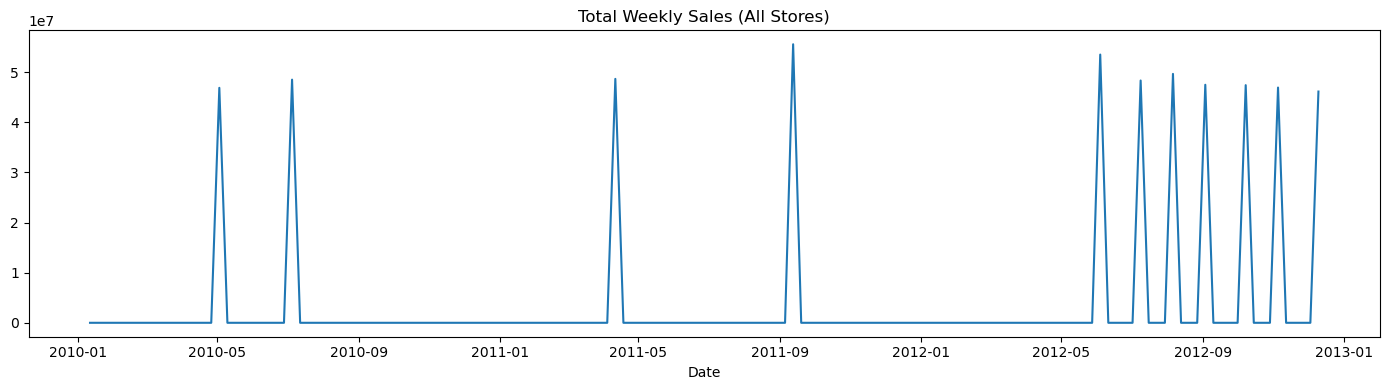

In [21]:
plt.figure(figsize=(14,4))
plot_series(agg_total.index, agg_total["Total_Weekly_Sales"], title="Total Weekly Sales (All Stores)")
plt.show()

In [32]:

  def baseline_forecasts(series, agg_df, test_weeks=12):
    train = series.iloc[:-test_weeks]
    test = series.iloc[-test_weeks:]
    results = {}

    # 1) Naive (last observed)
    last_val = float(train.iloc[-1])
    naive_forecast = pd.Series([last_val] * test_weeks, index=test.index)
    results["naive"] = {
        "forecast": naive_forecast,
        "metrics": evaluate(test.values, naive_forecast.values)
    }

    # 2) Seasonal naive (lag 24 weeks)
    seasonal_forecast = []
    for idx in test.index:
        lag_date = idx - pd.DateOffset(weeks=24)
        if lag_date in agg_df.index:
            seasonal_forecast.append(float(agg_df.loc[lag_date, agg_df.columns[0]]))
        else:
            seasonal_forecast.append(last_val)
    seasonal_forecast = pd.Series(seasonal_forecast, index=test.index)
    results["seasonal_naive"] = {
        "forecast": seasonal_forecast,
        "metrics": evaluate(test.values, seasonal_forecast.values)
    }

    # 3) Rolling mean (last 4 weeks)
    rolling_mean_val = float(train.iloc[-4:].mean())
    rolling_forecast = pd.Series([rolling_mean_val] * test_weeks, index=test.index)
    results["rolling_4wk"] = {
        "forecast": rolling_forecast,
        "metrics": evaluate(test.values, rolling_forecast.values)
    }

    return train, test, results

Baseline metrics (last 12 weeks):
- naive: {'RMSE': 23411117.5804685, 'MAE': 11704820.356666667, 'MAPE(%)': 25.0}
- seasonal_naive: {'RMSE': 28046780.741960842, 'MAE': 16163346.679166667, 'MAPE(%)': 4.4585263224999994e+17}
- rolling_4wk: {'RMSE': 20275722.64105541, 'MAE': 17639877.120416667, 'MAPE(%)': 8.902585145625e+17}


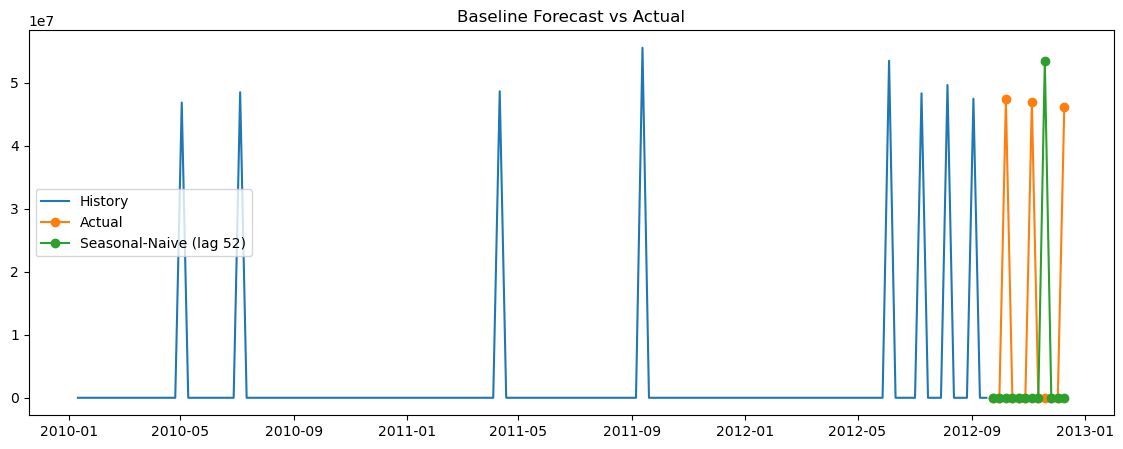

In [33]:
series = agg_total["Total_Weekly_Sales"]
train, test, baselines = baseline_forecasts(series, agg_total)

print("Baseline metrics (last {} weeks):".format(TEST_WEEKS))
for name, out in baselines.items():
    print(f"- {name}: {out['metrics']}")

# Plot seasonal-naive
plt.figure(figsize=(14,5))
plt.plot(train.index, train.values, label="History")
plt.plot(test.index, test.values, marker='o', label="Actual")
plt.plot(baselines['seasonal_naive']['forecast'].index,
         baselines['seasonal_naive']['forecast'].values,
         marker='o', label="Seasonal-Naive (lag 52)")
plt.title("Baseline Forecast vs Actual")
plt.legend()
plt.show()


In [34]:
def fit_sarimax(train_series, steps, exog_train=None, exog_forecast=None,
                order=(1,0,1), seasonal_order=(1,1,1,52), maxiter=100):
    try:
        model = SARIMAX(train_series, exog=exog_train, order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False, maxiter=maxiter)
        forecast_obj = res.get_forecast(steps=steps, exog=exog_forecast)
        pred_mean = forecast_obj.predicted_mean
        pred_ci = forecast_obj.conf_int()
        return res, pred_mean, pred_ci
    except Exception as e:
        print("SARIMAX fit failed:", e)
        return None, None, None

Fitting SARIMAX (may take some seconds)...
SARIMAX metrics: {'RMSE': 23411107.70685643, 'MAE': 11705020.62207553, 'MAPE(%)': 20514570737347.35}


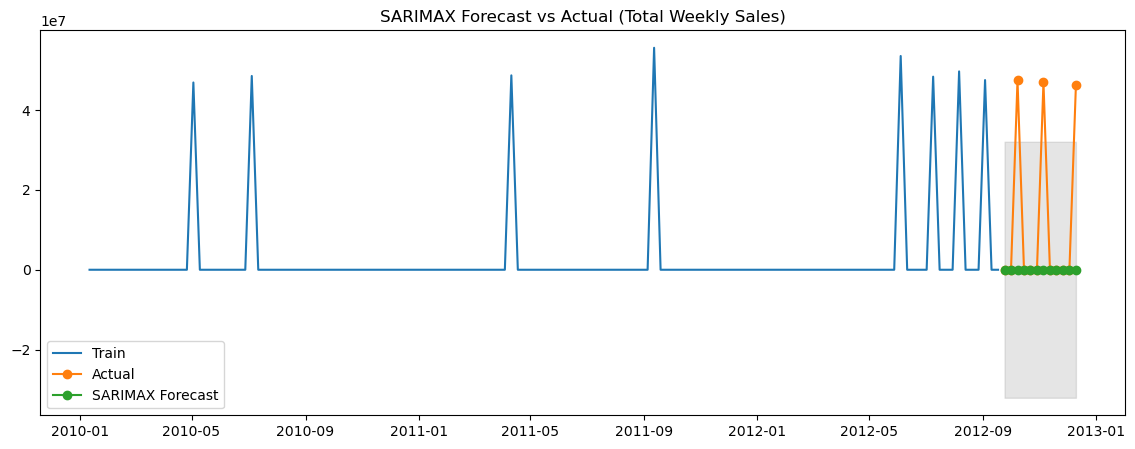

Saved SARIMAX model at forecast_outputs\sarimax_total_weekly.pkl


In [41]:
train_series = series.iloc[:-TEST_WEEKS]
test_series = series.iloc[-TEST_WEEKS:]
exog_present = [c for c in EXOG_COLS if c in agg_total.columns]
exog = agg_total[exog_present] if exog_present else None
exog_train = exog.iloc[:-TEST_WEEKS] if exog is not None else None
exog_test = exog.iloc[-TEST_WEEKS:] if exog is not None else None

print("Fitting SARIMAX (may take some seconds)...")
res, pred_mean, pred_ci = fit_sarimax(train_series, steps=TEST_WEEKS,
                                      exog_train=exog_train, exog_forecast=exog_test,
                                      order=(1,0,1), seasonal_order=(1,1,1,52))
if res is not None:
    sarimax_metrics = evaluate(test_series.values, pred_mean.values)
    print("SARIMAX metrics:", sarimax_metrics)

    plt.figure(figsize=(14,5))
    plt.plot(train_series.index, train_series.values, label="Train")
    plt.plot(test_series.index, test_series.values, marker='o', label="Actual")
    plt.plot(pred_mean.index, pred_mean.values, marker='o', label="SARIMAX Forecast")
    plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='gray', alpha=0.2)
    plt.legend()
    plt.title("SARIMAX Forecast vs Actual (Total Weekly Sales)")
    plt.show()
    joblib.dump(res, os.path.join(OUTPUT_DIR, "sarimax_total_weekly.pkl"))
    print("Saved SARIMAX model at", os.path.join(OUTPUT_DIR, "sarimax_total_weekly.pkl"))
else:
    print("SARIMAX model could not be fit — using baseline forecasts instead.")


In [48]:
store_sums = df.groupby(STORE_COL)[SALES_COL].sum().sort_values(ascending=False)
top_stores = store_sums.head(TOP_N_STORES).index.tolist()
print("Top stores:", top_stores)

per_store_metrics = []

for s in top_stores:
    print("\n>>> Store:", s)
    df_s = df[df[STORE_COL] == s].copy()
    agg_s = df_s.groupby(DATE_COL).agg({
        SALES_COL: "sum",
        **({c: "max" for c in EXOG_COLS if c in df_s.columns})
    }).rename(columns={SALES_COL: "Store_Sales"})
    agg_s = ensure_weekly_index(agg_s)
    agg_s["Store_Sales"] = agg_s["Store_Sales"].fillna(0)
    for c in EXOG_COLS:
        if c in agg_s.columns:
            agg_s[c] = agg_s[c].fillna(0)

    if len(agg_s) < (TEST_WEEKS + 10):
        print("  Not enough data for SARIMAX; using seasonal-naive baseline only.")
        _, _, bas = baseline_forecasts(agg_s["Store_Sales"], agg_s, test_weeks=min(TEST_WEEKS, max(4, int(len(agg_s)/4))))
        per_store_metrics.append({"store": s, "model": "seasonal_naive", **bas['seasonal_naive']['metrics']})
        continue
  

Top stores: [20, 4, 14, 13, 2]

>>> Store: 20

>>> Store: 4

>>> Store: 14

>>> Store: 13

>>> Store: 2


In [60]:
 naive_metric = baselines['naive']['metrics']
seasonal_metric = baselines['seasonal_naive']['metrics']
rolling_metric = baselines['rolling_4wk']['metrics']

print("Baseline Forecast Comparison:\n")
print("Naive Forecast:", naive_metric)
print("Seasonal Naive Forecast:", seasonal_metric)
print("Rolling 4-week Forecast:", rolling_metric)

Baseline Forecast Comparison:

Naive Forecast: {'RMSE': 23411117.5804685, 'MAE': 11704820.356666667, 'MAPE(%)': 25.0}
Seasonal Naive Forecast: {'RMSE': 28046780.741960842, 'MAE': 16163346.679166667, 'MAPE(%)': 4.4585263224999994e+17}
Rolling 4-week Forecast: {'RMSE': 20275722.64105541, 'MAE': 17639877.120416667, 'MAPE(%)': 8.902585145625e+17}


In [63]:
df['Date'] = pd.to_datetime(df['Date'])

# Aggregate total weekly sales for each Store
agg_stores = df.groupby(['Date', 'Store'])['Weekly_Sales'].sum().unstack(fill_value=0)

print("Aggregated data shape:", agg_stores.shape)
print("Number of stores:", len(agg_stores.columns))
agg_stores.head()

Aggregated data shape: (57, 45)
Number of stores: 45


Store,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2010-01-10,1453329.50,1827440.43,358784.10,1842821.02,283178.12,1328468.89,448998.73,804105.49,495692.19,1645892.97,1182490.46,850936.26,1765584.48,1855703.66,566945.95,463977.54,829207.27,948977.50,1379456.30,1933719.21,677158.39,905987.17,1129909.44,1215273.20,658640.14,923221.52,1543532.83,1203080.41,474698.01,445475.30,1213981.64,1061089.56,224294.39,865709.11,771065.21,422169.47,529877.93,360256.58,1219583.91,891152.33,1109216.35,481523.93,657108.77,300152.45,690007.76
2010-02-04,1594968.28,2066187.72,423294.40,1979247.12,331406.00,1770333.90,561145.14,914500.91,545206.32,2138651.97,1446210.26,1011822.30,2142482.14,2495630.51,718470.71,490503.69,848521.17,1254107.84,1642970.27,2405395.22,753664.12,1177340.99,1556627.62,1478321.26,822486.37,1029849.20,2053952.97,1441559.40,599629.25,457884.06,1357600.68,1131732.94,274634.52,979428.66,1189556.47,435972.82,540189.70,368929.55,1463942.62,1041202.13,1168826.39,505907.41,650102.80,286197.50,877235.96
2010-02-07,1492418.14,2003940.64,381151.72,1881337.21,305993.27,1759777.25,575570.77,852333.75,528832.54,1845893.87,1302600.14,951957.31,2018314.71,2334788.42,709337.11,610641.42,958875.37,1257928.35,1549018.68,2143676.77,711470.80,1120259.71,1549113.18,1563387.94,759407.87,1078455.48,2024554.10,1399960.15,581473.55,450337.47,1311704.92,1187988.64,267495.76,919229.36,1245827.08,434252.15,498292.53,361181.48,1352547.70,1087578.78,1273279.79,507168.80,667353.79,300628.19,800147.84
2010-03-09,1540163.53,1904608.09,366473.97,1935857.58,323798.00,1510925.32,532765.05,899036.47,511049.06,1766331.45,1303914.27,1075758.55,1911852.58,2182563.66,638647.21,542087.89,834373.73,1187359.77,1623519.64,2121561.41,727772.80,1074535.88,1405119.23,1366381.60,685700.08,1037549.71,1908110.90,1523410.71,579272.38,461548.98,1302047.48,1095932.51,237405.82,964356.74,948660.79,431294.45,510427.53,377096.55,1345167.61,976453.34,1223355.50,524658.06,689326.91,295880.12,790144.70
2010-03-12,1548033.78,2015781.27,476420.77,2102530.17,344490.88,1677067.24,552811.62,952766.93,578164.82,2251206.64,1380522.64,1069533.17,2083379.89,2258489.63,754134.95,512260.59,926573.81,1211026.13,1615987.96,2416051.17,829210.73,1230514.58,1617025.41,1413302.70,885572.96,1016143.64,1884343.67,1447916.29,642678.53,407112.22,1338716.37,1200892.56,209986.25,1001512.21,982598.88,360266.09,508213.14,351925.36,1431910.98,1000582.06,1220115.75,500250.80,557543.62,264214.12,879244.90


In [64]:
per_store_metrics = []

for s in agg_stores.columns:
    print(f"\nProcessing store: {s}")

    agg_s = agg_stores[[s]].rename(columns={s: "Store_Sales"})

    exog_s = agg_s[[c for c in EXOG_COLS if c in agg_s.columns]] if any(
        [c in agg_s.columns for c in EXOG_COLS]
    ) else None

    train_s = agg_s["Store_Sales"].iloc[:-TEST_WEEKS]
    test_idx_s = agg_s.index[-TEST_WEEKS:]
    exog_train_s = exog_s.iloc[:-TEST_WEEKS] if exog_s is not None else None
    exog_test_s = exog_s.iloc[-TEST_WEEKS:] if exog_s is not None else None

    res_s, pred_mean_s, pred_ci_s = fit_sarimax(
        train_s,
        steps=TEST_WEEKS,
        exog_train=exog_train_s,
        exog_forecast=exog_test_s,
        order=(1, 0, 1),
        seasonal_order=(1, 1, 1, 52)
    )

    if res_s is not None:
        metrics_s = evaluate(agg_s["Store_Sales"].iloc[-TEST_WEEKS:].values, pred_mean_s.values)
        per_store_metrics.append({"store": s, "model": "sarimax", **metrics_s})
        joblib.dump(res_s, os.path.join(OUTPUT_DIR, f"sarimax_store_{s}.pkl"))
        print("  SARIMAX fitted and saved.")
    else:
        per_store_metrics.append({"store": s, "model": "seasonal_naive", **seasonal_metric})
        print("  SARIMAX failed; seasonal-naive metrics used.")


Processing store: 1


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 2


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 3


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 4


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 5


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 6


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 7


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 8


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 9


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 10


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 11


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 12


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 13


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 14


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 15


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 16


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 17


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 18


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 19


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 20


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 21


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 22


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 23


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 24


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 25


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 26


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 27


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 28


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 29


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 30


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  SARIMAX fitted and saved.

Processing store: 31


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 32


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 33


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 34


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 35


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 36


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 37


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 38


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 39


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 40


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 41


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 42


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 43


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.

Processing store: 44


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init

  SARIMAX fitted and saved.

Processing store: 45


C:\Users\B.CHANDRIKA\anaconda4\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


  SARIMAX fitted and saved.
